In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import gym
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('CartPole-v1')
env.reset()
env.seed(0)
print("State shape: ",env.observation_space.shape)
print("Actions: ",env.action_space.n)

State shape:  (4,)
Actions:  2


In [3]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
device = torch.device('cuda:0')

In [4]:
class BaseDQN(nn.Module):
    def __init__(self,state_size,action_size,seed,fc1_units = 64,fc2_units = 32):
        super(BaseDQN,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc3 = nn.Linear(fc2_units,action_size)
    def forward(self,state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [5]:
class Agent():
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        #self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        #self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        #self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.basedqn_local = BaseDQN(state_size,action_size,seed).to(device)
        self.basedqn_target = BaseDQN(state_size,action_size,seed).to(device)
        self.optimizer = optim.Adam(self.basedqn_local.parameters(), lr = LR)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    """def _init_(self,state_size,action_size,seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        self.basedqn_local = BaseDQN(state_size,action_size,seed).to(device)
        self.basedqn_target = BaseDQN(state_size,action_size,seed).to(device)
        self.optimizer = optim.Adam(self.basedqn_local.parameters, lr = LR)
        self.memory = ReplayBuffer(action_size,BUFFER_SIZE,BATCH_SIZE,seed)
        self.t_step = 0"""
    def step(self,state,action,reward,next_state,done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step+1)%UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory.memory) >= BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences,GAMMA)
    def act(self,state,eps = 0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.basedqn_local.eval()
        with torch.no_grad():
            action_values = self.basedqn_local(state)
        self.basedqn_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    def learn(self,experiences,gamma):
        states, actions, rewards, next_states, dones = experiences
        Q_targets_next = self.basedqn_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + gamma*(Q_targets_next*(1-dones))
        Q_expected = self.basedqn_local(states).gather(1,actions)
        loss = F.mse_loss(Q_expected,Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.basedqn_local,self.basedqn_target,TAU)
    def soft_update(self,local_model,target_model,tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        

        
    
        

In [6]:
class ReplayBuffer:
    def __init__(self,action_size,buffer_size,batch_size,seed):
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names = ["state","action","reward","next_state","done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k = self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return states,actions,rewards,next_states,dones
    def some_len(self):
        return len(self.memory)      

In [7]:
agent = Agent(state_size=4, action_size=2, seed=0)
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state,reward,done,_ = env.step(action)
    if done:
        break

Episode 100	Average Score: 43.29
Episode 200	Average Score: 160.93
Episode 230	Average Score: 201.46
Environment solved in 130 episodes!	Average Score: 201.46


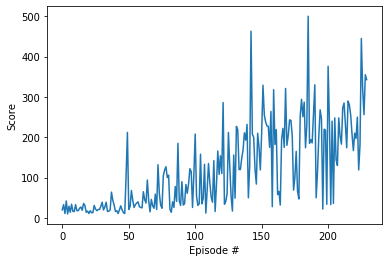

In [10]:
def basedqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen = 100)
    eps = eps_start
    for i_episode in range(1,n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            next_state,reward,done,_ = env.step(action)
            agent.step(state,action,reward,next_state,done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end,eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.basedqn_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = basedqn()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
agent.basedqn_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    for j in range(200):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()